# Parallel computation with Dask for InSAR applications

A practical introduction to parallel computation for DePSI developers.

<img src="figs/netherlands-escience-center-logo-RGB.svg" alt="nlesc-logo" width=50%/>

---

Why Dask? 

Disclaimer:

- It is not always faster than numpy;
- It is not always more efficient than numpy;

Dask is a solution for **Scaling Up** your computation with **Less pain**:

- Operates with larger-than-memory data;
- Use HPC resources efficiently;
- Minimal changes to your numpy code;

---

## Dask in a nutshell

<img src="figs/dask-overview.svg" alt="dask-overview" width=80%/>

## Configure scheduler

This is to tell Dask how to utilize the available resources.

Check [Dask documentation for scheduling](https://docs.dask.org/en/stable/scheduling.html) for more details.

If you execute this notebook on your local machine, choose one config from Single-machine scheduler or Distibuted schedular, do not execute all of them, since the last config will overwrite the previous ones.

### Single-machine scheduler


In [ ]:
import dask

# threaded scheduler, usually the default option
dask.config.set(scheduler='threads')  

In [ ]:
# process scheduler, not recommended by dask. Use local cluster instead.
dask.config.set(scheduler='processes')

In [ ]:
# force single-threaded execution, very useful for debugging
dask.config.set(scheduler='synchronous')

### Distributed

One can also use the distributed scheduler. This is especially useful when working on a HPC environment.

When you are working locally but not

In [ ]:
# Initiate a local cluster
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=2) # limit the concurrency resources to avoid memory issues

In [ ]:
# connect to cluster
client = Client(cluster)

In [ ]:
# Initiate a SLURM dask cluster
# We use this in HPC with SLURM system
# ONLY FOR DEMONSTRATION, NOT EXECUTABLE ON LOCAL

from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    name="dask-worker",  # Name of the Slurm job
    queue="normal", # Name of the node partition on your SLURM system
    cores=4, # Number of cores per worker
    memory="32 GB",  # Total amount of memory per worker
    processes=1,  # Number of Python processes per worker
    walltime="3:00:00",  # Reserve each worker for X hour
)

# connect to cluster
client = Client(cluster)

## Examples

Below we will show three examples of how Dask has been used for parallel computation in InSAR.

In [1]:
import xarray as xr
import numpy as np
import dask
import dask.array as da

In [2]:
stmat = xr.open_zarr('data/stm.zarr')
stmat

<xarray.Dataset> Size: 14MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

### Example 1: `da.apply_gufunc`

In this example, we consider parallelizing a function that only involves numpy arrays. We will extract real part from a complex array.

One real life example can be found in [DePSI/slc.py](https://github.com/TUDelftGeodesy/DePSI/blob/main/depsi/slc.py) reconstruct SLC complex from ifg and mother complex.

### Use numpy function on dask array directly

In [3]:
# Directly get the real part of the complex data
# This function is supported by numpy so can be parallelized directly
real_1 = stmat['complex'].data.real

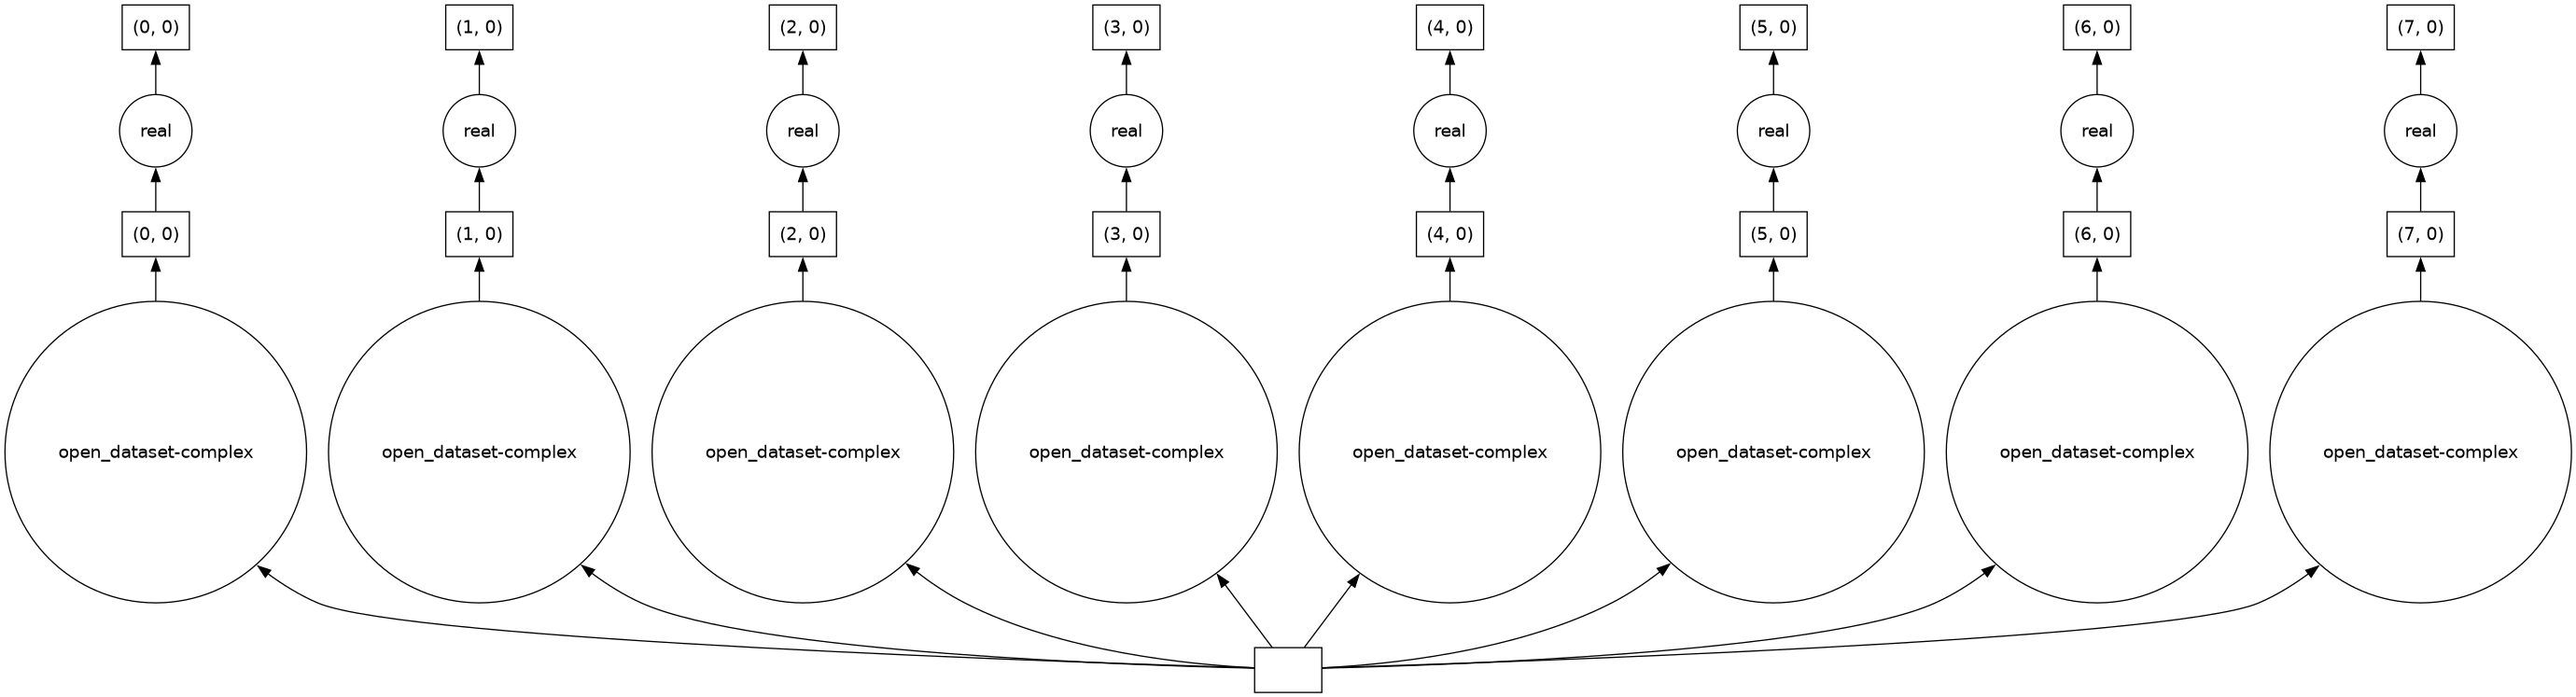

In [4]:
dask.visualize(real_1)

#### Write a function that takes numpy arrays as input, then vectorize it per block

In [5]:
# A function which takes an array
def get_real_array(complex):
    return complex.real

In [6]:
meta_arr = np.array((), dtype=np.float32)

real_2 = da.apply_gufunc(
    get_real_array,
    "()->()",
    stmat["complex"].data,
    meta=meta_arr,
)

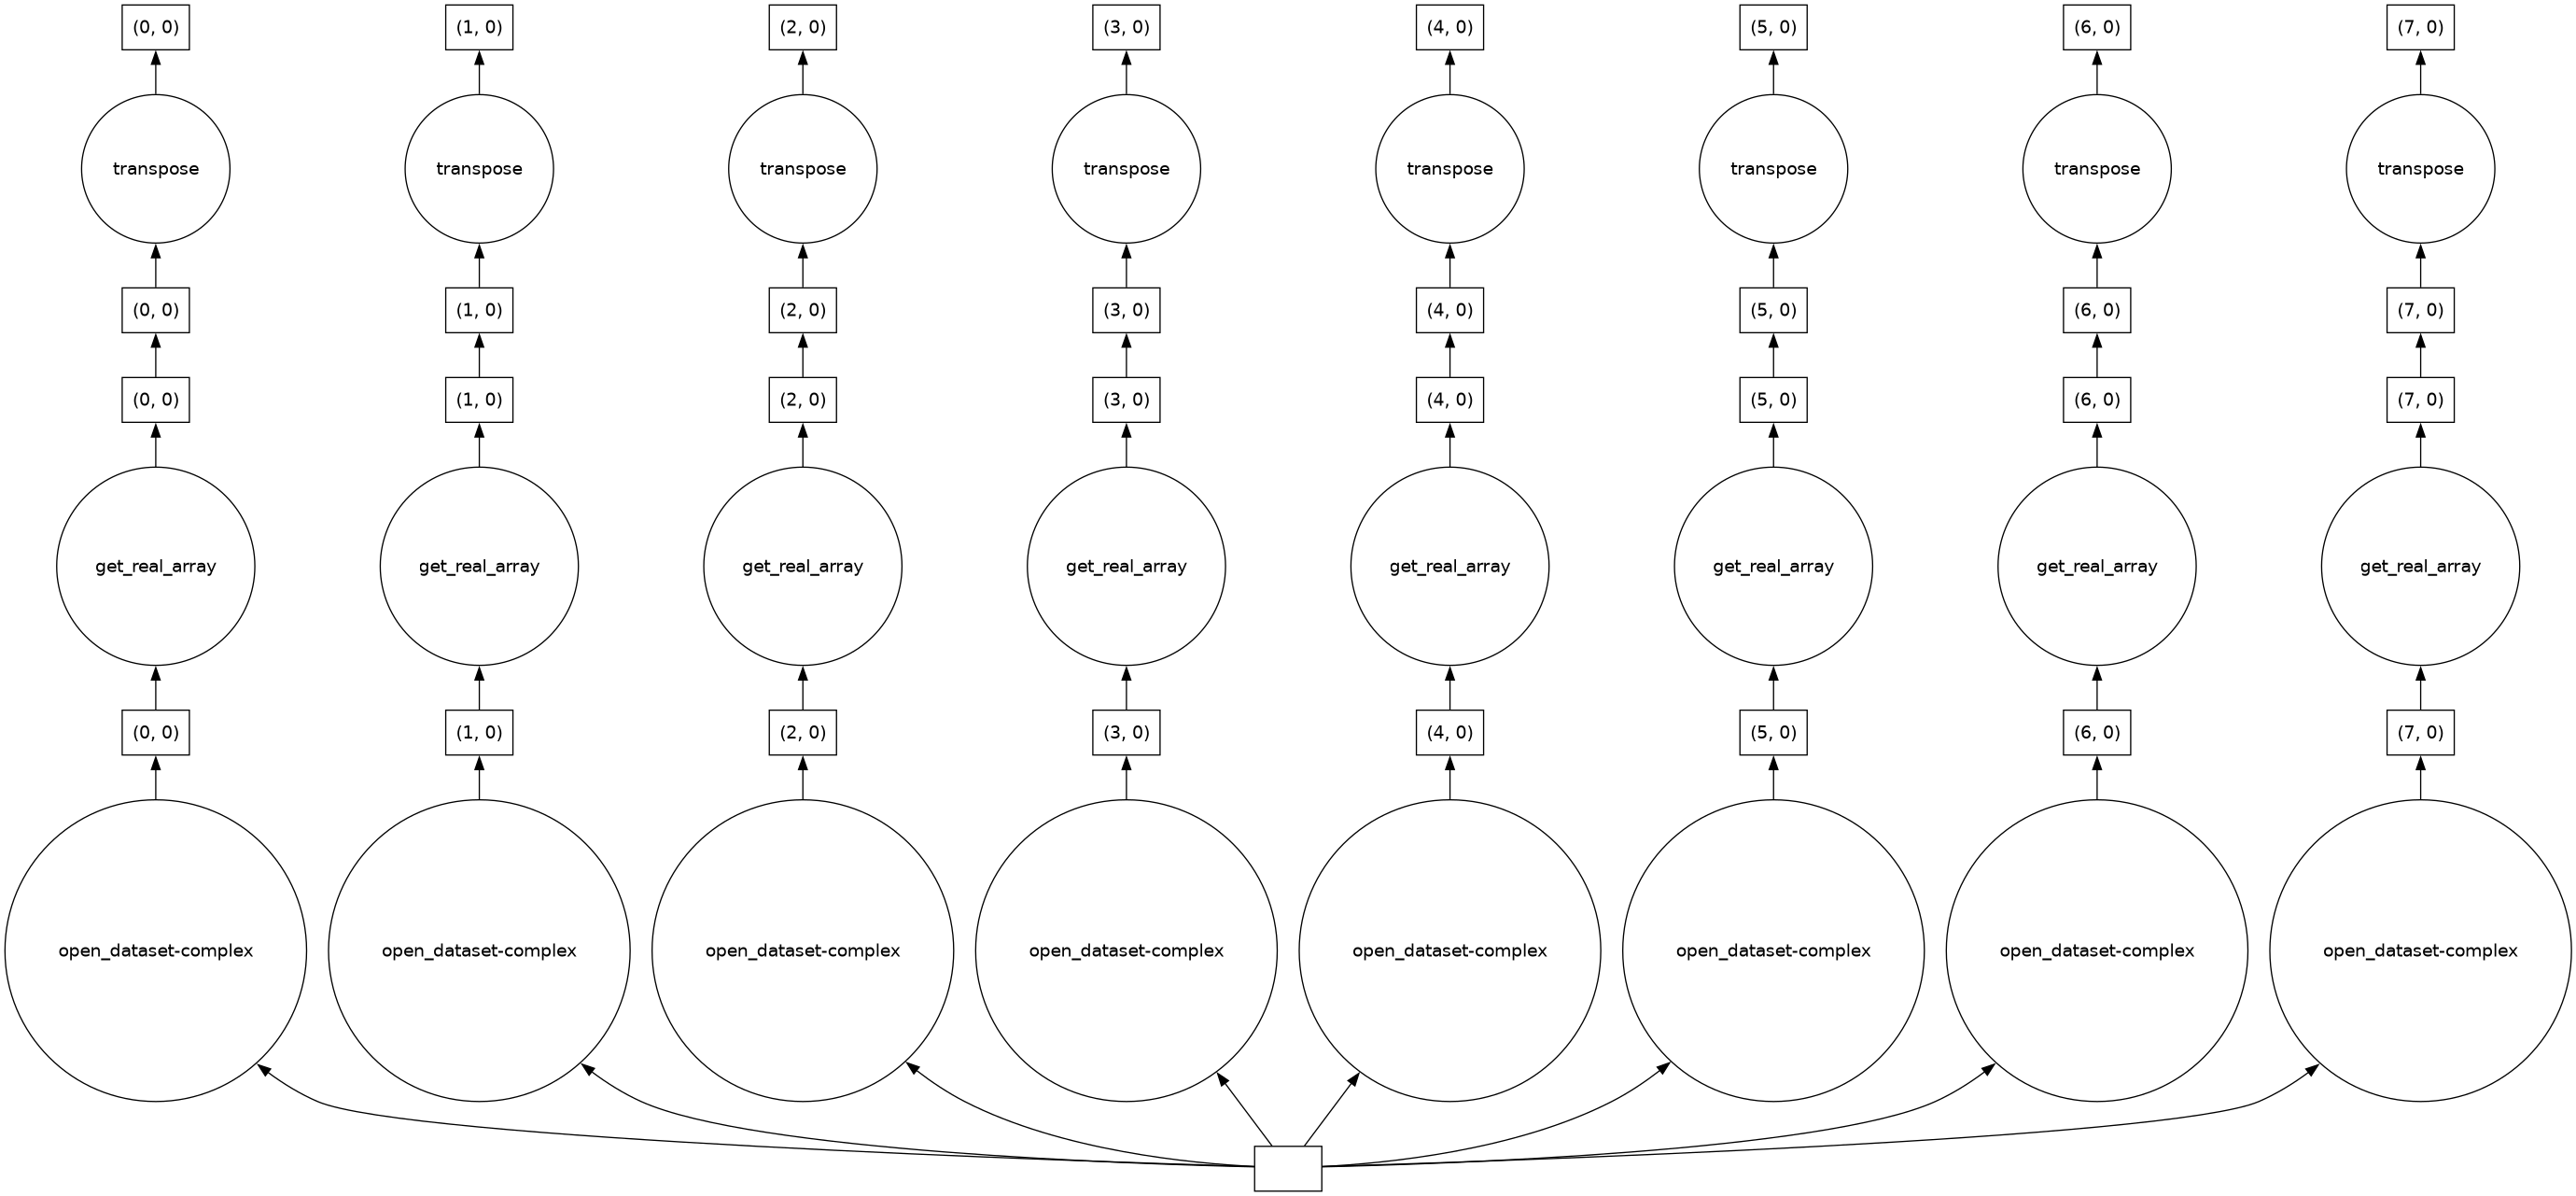

In [7]:
dask.visualize(real_2)

### Write a function that takes a single element as input

In [8]:
# A function which takes a single value 
@np.vectorize
def get_real_number(complex):
    if ~np.isnan(complex):
        return complex.real
    else:
        return np.nan

In [9]:
meta_arr = np.array((), dtype=np.float32)

real_3 = da.apply_gufunc(
    get_real_number,
    "()->()",
    stmat["complex"].data,
    meta=meta_arr,
)

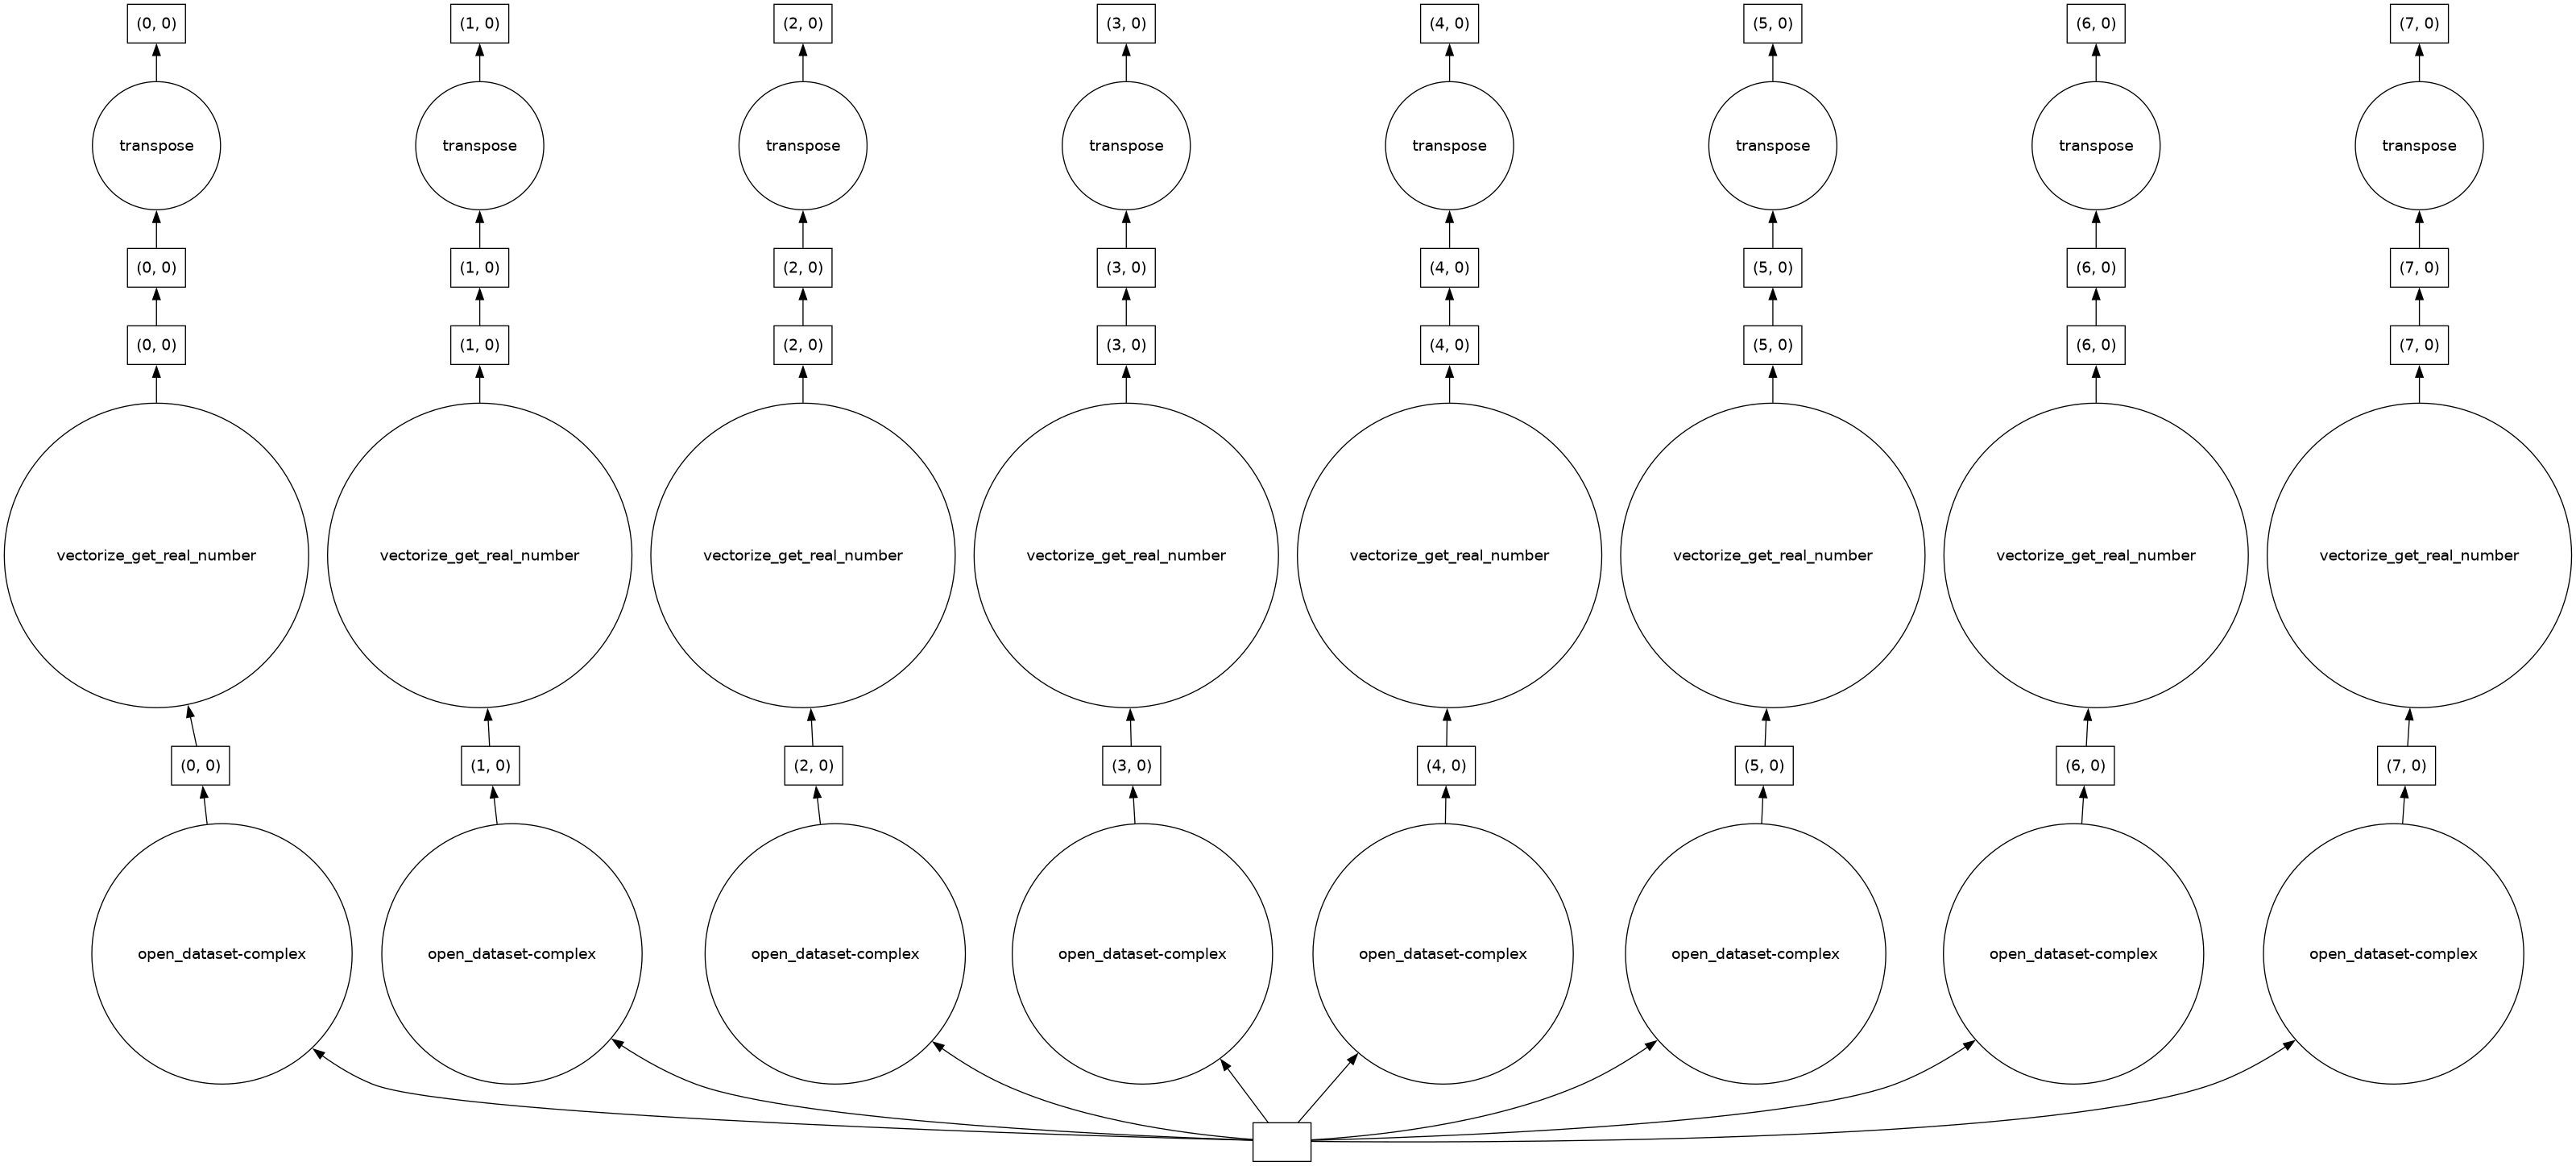

In [10]:
dask.visualize(real_3)

#### After building the task graph

In [11]:
# Re-assign to xarray dataset
stmat['real'] = (('space', 'time'), real_3)
stmat

<xarray.Dataset> Size: 18MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    real       (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [12]:
# Example of triggering the computation
real_3_comp = real_3.compute()
real_3_comp

array([[   514.93115,   -296.68585,    233.41502, ...,   -375.02396,
          -468.7583 ,    428.09406],
       [ -2632.2842 ,    776.7178 ,   2548.0337 , ...,   3019.0337 ,
         -3931.0288 ,   3837.6934 ],
       [     0.     ,      0.     ,      0.     , ...,      0.     ,
             0.     ,      0.     ],
       ...,
       [ 34810.37   , -15664.879  ,  66410.12   , ...,  45431.094  ,
         20597.82   , -53849.72   ],
       [ -5483.4355 ,  -6193.3354 ,    376.4837 , ...,   2700.0833 ,
          -306.2439 ,   4781.2935 ],
       [ -2147.1392 ,  -3128.516  ,   2229.8782 , ...,  -1608.2722 ,
          2551.9136 ,  -2731.8252 ]], dtype=float32)

### Question

What is the difference between `real_3.compute()` and `stmat['real'].compute()`?

## Example 2: map_blocks

In [ ]:
def enrich_from_polygon(self, polygon, fields, xlabel="lon", ylabel="lat"):

    ds = xr.map_blocks(
        _enrich_from_polygon_block,
        ds,
        args=(polygon, fields, xlabel, ylabel, type_polygon),
        template=ds,
    )

    return ds

In [ ]:
def _enrich_from_polygon_block(ds, polygon, fields, xlabel, ylabel, type_polygon):
    """Block-wise function for "enrich_from_polygon"."""
    # Get the match list
    match_list, polygon = _ml_str_query(ds[xlabel], ds[ylabel], polygon, type_polygon)

    _ds = ds.copy(deep=True)

    if match_list.ndim == 2:
        intuids = np.unique(match_list[:, 0])
        for intuid in intuids:
            intm = np.where(match_list[:, 0] == intuid)[0]
            intmid = match_list[intm, 1]
            for field in fields:
                _ds[field].data[intmid] = polygon.iloc[intuid][field]

    return _ds

## Example 3: groupby + map + map_blocks

In [ ]:
def full_batch_one_group(stm_pnt, slc_quality_ref, h2ph_ref):
    
    # stm_pnt = stm_pnt.compute()
    slc_quality_pnts = stm_pnt['slc_quality']
    h2ph_pnts = stm_pnt['h2ph_values']
    dd_arc = stm_pnt['dd_complex']
    # # Compute the diagonal of the VCM of the dd phases
    Qyy_diagonal = np.sqrt((slc_quality_ref)**2 + (slc_quality_pnts)**2)


    # Compute the variance covariance matrix of the DD based on the NMAD for the arc
    Qyy = np.identity(len(stm_pnt.time))*Qyy_diagonal.to_numpy()**2

    # Compute 'mean' h2ph value for the arc (which we currently model as the average of the two time series)
    
    h2ph_arc = (h2ph_ref + h2ph_pnts)/2
    # h2ph_arc = h2ph_arc.to_numpy()
    h2ph_arc = h2ph_arc.squeeze().values

    # Get the wrapped phase
    phs_wrapped = np.angle(dd_arc)
    phs_wrapped = phs_wrapped.squeeze()

    # Define y and the corresponding VQM Qyy
    # y = np.append(phs_wrapped, [0, 0, 0, 0])
    Q_phs = Qyy
    Q_b = np.diag([sigma_offset**2, sigma_vel**2, sigma_h**2, sigma_ther**2])
    # Qyy = np.block([[Q_phs, np.zeros((Q_phs.shape[0], Q_b.shape[1]))],
    #                 [np.zeros((Q_b.shape[0], Q_phs.shape[1])), Q_b]])

    # Define the design matrices
    A1 = np.diag([-2*np.pi] * len(phs_wrapped))
    # B2 = np.diag([1] * 4)
    # C = np.block([[A1, np.zeros((A1.shape[0], B2.shape[1]))],
    #                 [np.zeros((B2.shape[0], A1.shape[1])), B2]])

    B1 = np.ones((phs_wrapped.shape[0],4))
    B1[:,1] = years*(-4*np.pi/wavelength/1000)
    B1[:,2] = h2ph_arc*(-4*np.pi/wavelength)
    B1[:,3] = temp*(-4*np.pi/wavelength/1000)
    # C[:len(phs_wrapped), -4:] = B1

    # Float solution with least-squares
    ahat = phs_wrapped/(-2*np.pi)
    Qahat = 1/(4*((np.pi)**2)) * (Q_phs + B1@Q_b@B1.T)


    # Lambda method - Integer bootstrapping
    afixed,sqnorm,Ps,Qzhat,Z,nfixed,mu = LAMBDA.main(ahat,Qahat,3)

    # Calculate the unwrapped phase [rad]
    phs_unw  = phs_wrapped - A1@afixed
    
    # Get the estimated parameters
    b_hat = np.linalg.inv((B1.T@np.linalg.inv(Q_phs)@B1))@B1.T@np.linalg.inv(Q_phs)@phs_unw
    
    # Get the phase for estimated DD observation, non-thermal displacement, height difference and thermal expension [rad]
    phs_est = B1@b_hat
    phs_dis =  B1[:,:2]@b_hat[:2]
    phs_height = B1[:,2]*b_hat[2]
    phs_ther = B1[:,3]*b_hat[3]

    # Get the phase for estimated DD observation, non-thermal displacement, height difference and thermal expension [mm]
    dis_est = phs_est*(-wavelength/(4*np.pi)*1000)
    dis_dis = phs_dis*(-wavelength/(4*np.pi)*1000)
    dis_height = phs_height*(-wavelength/(4*np.pi)*1000)
    dis_ther = phs_ther*(-wavelength/(4*np.pi)*1000)

    # Get the wrapped and unwrapped phase [mm]
    dis_wrapped = phs_wrapped*(-wavelength/(4*np.pi)*1000)
    dis_unw = phs_unw*(-wavelength/(4*np.pi)*1000)

    ds_out = stm_pnt.copy()
    ds_out = ds_out.assign(dis_wrapped=((ds_out.dims), np.expand_dims(dis_wrapped, axis=0)))
    ds_out = ds_out.assign(dis_unw=((ds_out.dims), np.expand_dims(dis_unw, axis=0)))
    ds_out = ds_out.assign(dis_est=((ds_out.dims), np.expand_dims(dis_est, axis=0)))
    ds_out = ds_out.assign(dis_dis=((ds_out.dims), np.expand_dims(dis_dis, axis=0)))
    ds_out = ds_out.assign(dis_height=((ds_out.dims), np.expand_dims(dis_height, axis=0)))
    ds_out = ds_out.assign(dis_ther=((ds_out.dims), np.expand_dims(dis_ther, axis=0)))

    ds_out['vel'] = xr.DataArray(np.array([b_hat[1]]), dims=('space'), coords={'space': ds_out.space.values})
    ds_out['height'] = xr.DataArray(np.array([b_hat[2]]), dims=('space'), coords={'space': ds_out.space.values})
    ds_out['ther'] = xr.DataArray(np.array([b_hat[3]]), dims=('space'), coords={'space': ds_out.space.values})

    return ds_out

In [ ]:
def full_batch_chunk(ds, sd_complex_ref, slc_quality_ref, h2ph_ref):
    """
    Given temporal differnces of point i and point j we compute the double difference phase 
    We also compute the quality of the arc time series 

    point i is the reference point and is subtracted from point j:
    sd_complex_conj_i = sd_complex_i.conj()
    dd_arc = sd_complex_j*sd_complex_conj_i

    Remark that the output of the quality is the sigma of the DD phase. 

    Example:
        dd_arc, Qyy_diagonal_sigma = compute_dd(sd_complex_i, sd_complex_j,sd_quality_i, sd_quality_j, plot, dates, mother_idx)


    Code is as follows:
        sd_complex_conj_i = sd_complex_i.conj()
        dd_arc = sd_complex_j*sd_complex_conj_i
       
        Qyy_diagonal_sigma = np.sqrt((sd_quality_i)**2 + (sd_quality_j)**2)
    """
    ds_out = ds.copy()
    slc_complex_pnts =  ds['sd_complex']
    # slc_quality_pnts = ds['slc_quality']
    sd_complex_conj_ref = sd_complex_ref.conj()
    dd_arc = slc_complex_pnts*sd_complex_conj_ref

    # # # Compute the diagonal of the VCM of the dd phases
    # Qyy_diagonal = np.sqrt((slc_quality_ref)**2 + (slc_quality_pnts)**2)

    ds_out['dd_complex'] = dd_arc
    # ds_out['Qyy_diagonal'] = Qyy_diagonal
    # ds_out['h2ph_arc'] = h2ph_arc

    # # Load chunk in memory
    # ds_out = ds_out.compute()

    groups = ds_out.groupby("space")
    ds_analysis = groups.map(
        full_batch_one_group,
        slc_quality_ref = slc_quality_ref, 
        h2ph_ref = h2ph_ref
    )

    return ds_analysis

In [ ]:
stm_new2 = xr.map_blocks(full_batch_chunk, stm_new_in, kwargs = {"sd_complex_ref": sd_complex_ref_com, "slc_quality_ref": slc_quality_ref_com, "h2ph_ref": h2ph_ref_com}, template = stm_new_in)
stm_new2